In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import networkx as nx
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
data_folder = './BeerAdvocate/'

In [256]:
df_beers = pd.read_pickle(data_folder + 'beers.pkl')
df_breweries = pd.read_pickle(data_folder + 'breweries.pkl')
df_users = pd.read_pickle(data_folder + 'users.pkl')
df = pd.read_pickle(data_folder + 'ratings.pkl')

### Descriptive analysis of beer styles 

In [258]:
# We merge the ratings with the beer dataset to get the style for each beer and the brewery id
df_merged = df.merge(df_beers[['beer_id','brewery_id','style','abv']], left_on='beer_id', right_on='beer_id')

In [259]:
df_merged.head()

,beer_id,date,user_id,appearance,aroma,palate,taste,overall,rating,review,brewery_id,style,abv
0,142544,2015-08-20 10:00:00,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,True,37262,Euro Pale Lager,4.5
1,19590,2009-02-20 11:00:00,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,True,10093,English Pale Ale,4.5
2,19590,2006-03-13 11:00:00,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,True,10093,English Pale Ale,4.5
3,19590,2004-12-01 11:00:00,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,True,10093,English Pale Ale,4.5
4,19590,2004-08-30 10:00:00,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,True,10093,English Pale Ale,4.5


In [260]:
# merge the df_ba dataset with the df_breweries dataset to get the location where the beers are brewed
df_merged = df_merged.merge(df_breweries[['id','location']], left_on='brewery_id', right_on='id')

# convert dates to datetime
df_merged["date"] = df_merged["date"].apply(pd.to_datetime,unit='s')

# creates column with corresponding country where  beer is brewed
countries = ["United States","Canada","Utah","England","Wales","Scotland"]
df_merged["country"] = df_merged["location"]
for country in countries:
    df_merged["bool"] = df_merged["location"].apply(lambda x: country in x)
    if country == "Utah":
        country = "United States"
    df_merged.loc[df_merged["bool"],"country"] = country
    del df_merged['bool']
    
df_merged.head()

,beer_id,date,user_id,appearance,aroma,palate,taste,overall,rating,review,brewery_id,style,abv,id,location,country
0,142544,2015-08-20 10:00:00,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,True,37262,Euro Pale Lager,4.5,37262,Gabon,Gabon
1,19590,2009-02-20 11:00:00,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,True,10093,English Pale Ale,4.5,10093,Northern Ireland,Northern Ireland
2,19590,2006-03-13 11:00:00,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,True,10093,English Pale Ale,4.5,10093,Northern Ireland,Northern Ireland
3,19590,2004-12-01 11:00:00,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,True,10093,English Pale Ale,4.5,10093,Northern Ireland,Northern Ireland
4,19590,2004-08-30 10:00:00,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,True,10093,English Pale Ale,4.5,10093,Northern Ireland,Northern Ireland


In [261]:
# creates column with corresponding user country
df_users["user_country"] = df_users["location"]
for country in countries:
    df_users["bool"] = df_users[df_users["location"].notnull()]["location"].apply(lambda x: country in x)
    if country == "Utah":
        country = "United States"
    df_users.loc[df_users["bool"] == True,"user_country"] = country
    del df_users['bool']

In [262]:
df_users.columns = ["user_nbr_ratings", "user_nbr_reviews", "user_id", "user_name", "date_joined", "location", "user_country"]

In [268]:
# merge ratings with user dataset to get user country and number of ratings 
df = df_merged[["user_id", "date", "aroma", "palate", "taste", "overall", "rating","abv", "style", "country"]].merge(df_users[['user_nbr_ratings','user_nbr_reviews','user_id','user_country']], left_on='user_id', right_on='user_id')

In [269]:
df.head()

,user_id,date,aroma,palate,taste,overall,rating,abv,style,country,user_nbr_ratings,user_nbr_reviews,user_country
0,nmann08.184925,2015-08-20 10:00:00,2.75,3.25,2.75,3.00,2.88,4.5,Euro Pale Lager,Gabon,7820,465,United States
1,nmann08.184925,2015-11-14 11:00:00,3.50,3.75,3.50,3.50,3.56,5.0,Extra Special / Strong Bitter (ESB),Wales,7820,465,United States
2,nmann08.184925,2011-11-18 11:00:00,NaN,NaN,NaN,NaN,4.50,8.0,Old Ale,Scotland,7820,465,United States
3,nmann08.184925,2013-05-03 10:00:00,NaN,NaN,NaN,NaN,3.75,10.5,Old Ale,Scotland,7820,465,United States
4,nmann08.184925,2015-01-24 11:00:00,3.50,3.75,4.00,3.75,3.81,6.0,English Porter,Scotland,7820,465,United States


In [270]:
types_features = []
types_features.append(["amber ale", "american pale ale", "english pale ale", "blonde ale", "bitter"])     #Pale Ales
types_features.append(["amber lager", "dunkel", "marzen", "oktoberfest", "schwarzbier", "vienna lager", "dark lager", "red lager"])    #Dark Lagers
types_features.append(["brown ale", "mild"])     #Brown Ales
types_features.append(["ipa", "indian pale ale"])     #India Pale Ales
types_features.append(["wheat wine ale", "wheat", "witbier", "weisse", "weissbier", "dunkelweizen", "hefeweizen", "kristalweizen"])     #Wheat Beers
types_features.append(["barley wine", "barleywine",  "imperial red ale", "barley wine ale", "old ale", "strong ale", "strong pale ale"])     #Strong Ales
types_features.append(["belgian blonde ale", "dubbel", "belgian strong dark ale", "belgian dark ale", "golden strong ale", "belgian pale ale", "quadrupel", "saison", "tripel"])     #Belgian Styles
types_features.append(["cream ale", "biere de garde", "bière de garde", "common", "altbier", "kolsch", "kölsch", "red beer", "red ale"])     #Hybrid Beers
types_features.append(["porter"])     #Porters
types_features.append(["stout"])     #Stouts
types_features.append(["bock", "doppelbock", "maibock", "weizenbock"])     #Bocks
types_features.append(["heavy", "scottish ale"])     #Scottish-Style Ales
types_features.append(["brett", "sour", "flanders", "lambic", "faro", "gueuze", "gose", "wild"])     #Wild/Sour Beers
types_features.append(["pale lager", "american Lager", "american adjunct lager", "pilsener", "pilsner", "export", "helles"])     #Pilseners and Pale Lagers
types_features.append(["black ale", "barrel-aged", "chocolate", "coffee", "fruit", "field", "craft", "herb", "spice", "honey", "pumpkin", "rye", "roggenbier", "session", "smoke", "rauchbier", "specialty", "sahti"])     #Specialty Beers

In [271]:
types = {}
i = 1
for type_features in types_features:
    for key in type_features:
        types[key] = i
    i += 1

In [272]:
df["style_merged"] = 15
for type, label in types.items():
    df["bool"] = df["style"].apply(lambda x: type in x.lower())
    df.loc[df["bool"], "style_merged"] = label
    del df['bool']
df['style_merged'] = df['style_merged'].astype("string")
df.head()

,user_id,date,aroma,palate,taste,overall,rating,abv,style,country,user_nbr_ratings,user_nbr_reviews,user_country,style_merged
0,nmann08.184925,2015-08-20 10:00:00,2.75,3.25,2.75,3.00,2.88,4.5,Euro Pale Lager,Gabon,7820,465,United States,14
1,nmann08.184925,2015-11-14 11:00:00,3.50,3.75,3.50,3.50,3.56,5.0,Extra Special / Strong Bitter (ESB),Wales,7820,465,United States,1
2,nmann08.184925,2011-11-18 11:00:00,NaN,NaN,NaN,NaN,4.50,8.0,Old Ale,Scotland,7820,465,United States,6
3,nmann08.184925,2013-05-03 10:00:00,NaN,NaN,NaN,NaN,3.75,10.5,Old Ale,Scotland,7820,465,United States,6
4,nmann08.184925,2015-01-24 11:00:00,3.50,3.75,4.00,3.75,3.81,6.0,English Porter,Scotland,7820,465,United States,9


In [283]:
# create dataframe to analyse the production countries, rating countries and abv ranges of each beer style 
df_styles = pd.DataFrame(columns=['style','main_substyle','number of substyles', 'main_production_country', 'nbr_production_countries', 'main_rating_country', 'nbr_rating_countries', 'avg_ratings', 'abv_range'])
for style, group in df.groupby(["style_merged"]):
    by_country = {
        'style': [style],
        'main_substyle': [group["style"].value_counts().keys()[group["style"].value_counts().argmax()]],
        'number of substyles': [len(group["style"].unique())],
        'main_production_country': [group["country"].value_counts().keys()[group["country"].value_counts().argmax()]],
        'nbr_production_countries': [len(group["country"].unique())],
        'main_rating_country': [group["user_country"].value_counts().keys()[group["user_country"].value_counts().argmax()]],
        'nbr_rating_countries': [len(group["user_country"].unique())],
        'avg_ratings': [np.nanmean(group["rating"])],
        'abv_range': [[group["abv"].min(), group["abv"].max()]]
    }
    df_styles = pd.concat([df_styles, pd.DataFrame(by_country)], axis=0)

df_styles.reset_index(drop=True, inplace=True)

In [287]:
df_styles

,style,main_substyle,number of substyles,main_production_country,nbr_production_countries,main_rating_country,nbr_rating_countries,avg_ratings,abv_range
0,1,American Pale Ale (APA),5,United States,97,United States,111,3.756001,"[1.4, 14.1]"
1,10,American Double / Imperial Stout,7,United States,88,United States,113,4.127981,"[1.0, 40.0]"
2,11,Doppelbock,4,United States,58,United States,90,3.850055,"[3.4, 65.0]"
3,12,Scotch Ale / Wee Heavy,2,United States,43,United States,81,3.902776,"[2.7, 20.2]"
4,13,American Wild Ale,7,United States,42,United States,85,4.128377,"[1.3, 25.0]"
5,14,American Adjunct Lager,10,United States,176,United States,120,3.337627,"[0.5, 17.0]"
6,15,Fruit / Vegetable Beer,24,United States,125,United States,114,3.576524,"[0.01, 28.0]"
7,2,Märzen / Oktoberfest,6,United States,104,United States,102,3.583071,"[2.0, 11.9]"
8,3,American Brown Ale,4,United States,65,United States,92,3.773366,"[2.0, 15.0]"
9,4,American IPA,4,United States,83,United States,120,4.024632,"[0.5, 41.0]"


We notice from this dataframe that the beer styles are all rated and produced mostly in the United States. The best rated supra-style on average is the wild/sour ales style. 

To get an idea on how the production and ratings are distributed for a specific style, we plot the histograms.

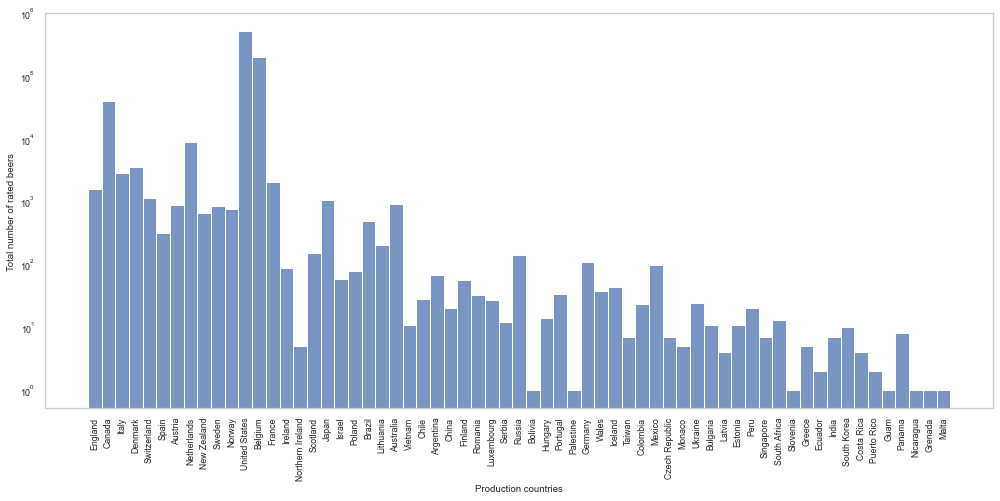

In [306]:
#define Seaborn color palette to use
sns.set(font_scale=1)
sns.set_style("whitegrid")
colors = sns.color_palette("colorblind", 16)

fig, ax = plt.subplots(figsize=(17, 7.27))
sns.histplot(df[df["style_merged"]=="7"].country, ax=ax, bins=len(df[df["style_merged"]=="7"].country.unique()))
ax.set_yscale('log')
ax.set_xlabel('Production countries')
ax.set_ylabel('Total number of rated beers ')
ax.grid(False)
plt.xticks(rotation=90)
plt.show()

In our dataset, the 3 countries that produce the most Belgian styles are the United States, Belgium and Canada. 

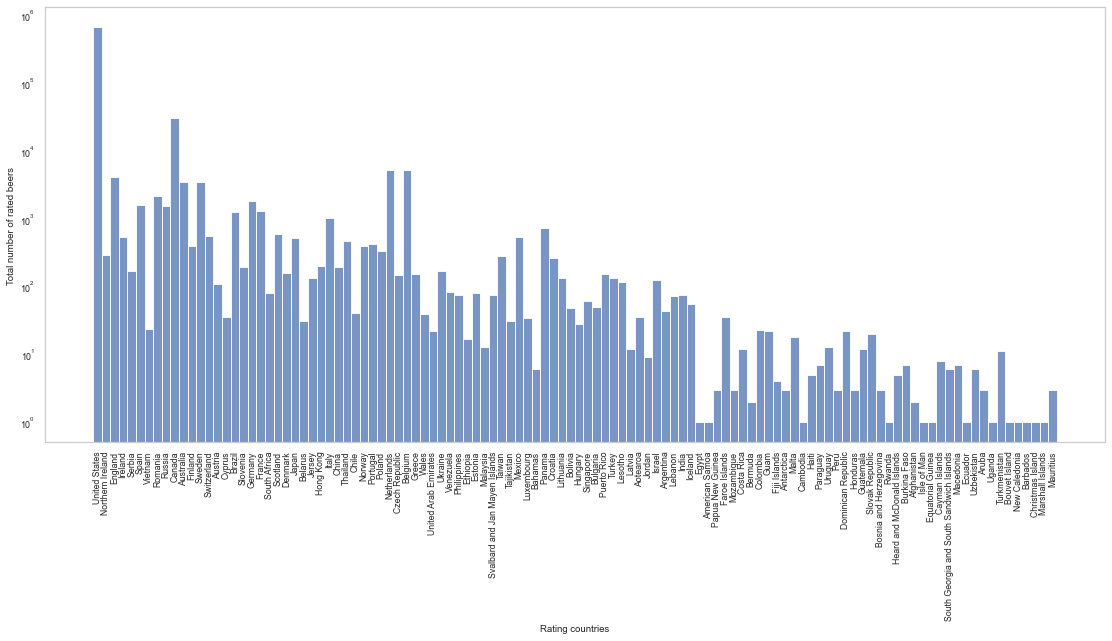

In [311]:
sns.set(font_scale=0.8)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(19, 8))
sns.histplot(df[df["style_merged"]=="7"].user_country, ax=ax, bins=len(df[df["style_merged"]=="7"].user_country.unique()))
ax.set_yscale('log')
ax.set_xlabel('Rating countries')
ax.set_ylabel('Total number of rated beers ')
ax.grid(False)
plt.xticks(rotation=90)
plt.show()

In our dataset, the 3 countries that rate the most Belgian styles are the United States, Belgium and Canada. 

### Categorization of the users justificative analysis

First of all, to get an idea of the user preferences depending on the country of origin and the experience (number of ratings) for a user we will conduct a regression analysis predicting the favorite style of a user based on his country of origin and his number of  previous ratings. 

In [59]:
# create dictionary with beers rated for each user
df_grouped_by_user = df.groupby("user_id")
users_dict = {}
for key,group in df.groupby("user_id"):
    users_dict[key] = pd.DataFrame(columns=['aroma','palate','taste','overall','rating','style','country','user_nbr_ratings','user_nbr_reviews','user_country','style_merged'])
    users_dict[key] = group

In [60]:
# summerize the dictionary into a new dataframe 
df_summary = pd.DataFrame(columns=['user','total_ba_ratings','country', 'main_country_rated', 'nbr_countries_rated', 'fav_country', 'main_style_rated', 'nbr_styles_rated','fav_style','fav_merged_style','total_ratings'])
for key in users_dict:
    by_user = {
        'user': [key],
        'country': [users_dict[key]["user_country"].iloc[0]],
        'main_country_rated':[users_dict[key]["country"].value_counts().keys()[
            users_dict[key]["country"].value_counts().argmax()]],
        'nbr_countries_rated':[users_dict[key]["country"].nunique()],
        'fav_country':[users_dict[key].sort_values(by="rating",ascending=False)["country"][:3].value_counts().keys()[
            users_dict[key].sort_values(by="rating",ascending=False)["country"][:3].value_counts().argmax()]],
        'main_style_rated': [users_dict[key]["style"].value_counts().keys()[
            users_dict[key]["style"].value_counts().argmax()]],
        'nbr_styles_rated': [users_dict[key]["style"].nunique()],
        'fav_style':[users_dict[key].sort_values(by="rating",ascending=False)["style"][:3].value_counts().keys()[
            users_dict[key].sort_values(by="rating",ascending=False)["style"][:3].value_counts().argmax()]],
        'fav_merged_style':[users_dict[key].sort_values(by="rating",ascending=False)["style_merged"][:3].value_counts().keys()[
            users_dict[key].sort_values(by="rating",ascending=False)["style_merged"][:3].value_counts().argmax()]],
        'total_ratings': [users_dict[key]["user_nbr_ratings"].iloc[0]],
    }
    df_summary = pd.concat([df_summary, pd.DataFrame(by_user)], axis=0)
    
df_summary.reset_index(drop=True, inplace=True)

In [67]:
df_summary["total_ratings"] = df_summary["total_ratings"].astype("int")
df_summary.head()

,user,total_ba_ratings,country,main_country_rated,nbr_countries_rated,fav_country,main_style_rated,nbr_styles_rated,fav_style,fav_merged_style,total_ratings
0,-----kiki-----.1000245,2,NaN,United States,1,United States,American Pale Lager,2,American Double / Imperial IPA,4,2
1,---.940711,3,NaN,United States,1,United States,American Pale Wheat Ale,3,American Pale Wheat Ale,4,3
2,--dida--.1042029,3,Canada,Canada,2,Canada,Cream Ale,3,American Double / Imperial IPA,4,3
3,--dom--.709199,165,United States,United States,8,United States,American Double / Imperial IPA,31,American Barleywine,6,165
4,--nomad--.931404,1,United States,United States,1,United States,American IPA,1,American IPA,4,1


In [68]:
one_hot_df = pd.get_dummies(df_summary[["country","fav_merged_style","total_ratings"]])

In [96]:
new_col = pd.DataFrame(np.array(one_hot_df.columns))
new_col[0] = new_col[0].astype("string").apply(lambda x: x.replace(" ", "_"))
one_hot_df.columns = new_col[0].values

Now we can compute a regression that predicts the probability that a given style will be a user favorite depending on the country and the number of ratings of a user. 

For example, we can compute the probability that IPA's are the favorite style for a user coming either from Belgium or the United states, depending on his number of ratings. 

In [102]:
mod = smf.ols(formula='fav_merged_style_4 ~ total_ratings + country_Belgium + country_United_States',data=one_hot_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     fav_merged_style_4   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     132.0
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           2.08e-85
Time:                        14:00:31   Log-Likelihood:                -99452.
No. Observations:              153704   AIC:                         1.989e+05
Df Residuals:                  153700   BIC:                         1.990e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.28

In [105]:
res.params.values

array([ 2.83744080e-01, -5.11186811e-05, -2.22764637e-01,  4.06543568e-02])

From the coefficients obtained, we can see that a user coming from the United States and having a low number of ratings (i.e. not experienced user) is more likely to prefer IPA's than a user coming from Belgium and having a high number of ratings (i.e. experienced user).

We can plot these regressions for 4 different styles and countries to compare: 

In [175]:
countries = ["country_United_States", "country_Belgium", "country_Canada", "country_Germany"]
styles = ["fav_merged_style_4", "fav_merged_style_7", "fav_merged_style_10","fav_merged_style_14"]
coefficients = []
for style in styles:
    coefficients_by_country = []
    for country in countries:
        regression_formula = style + ' ~ total_ratings + ' + country
        mod = smf.ols(formula=regression_formula,data=one_hot_df)
        res = mod.fit()
        coefficients_by_country.append(res.params.values)
    coefficients.append(coefficients_by_country)
    

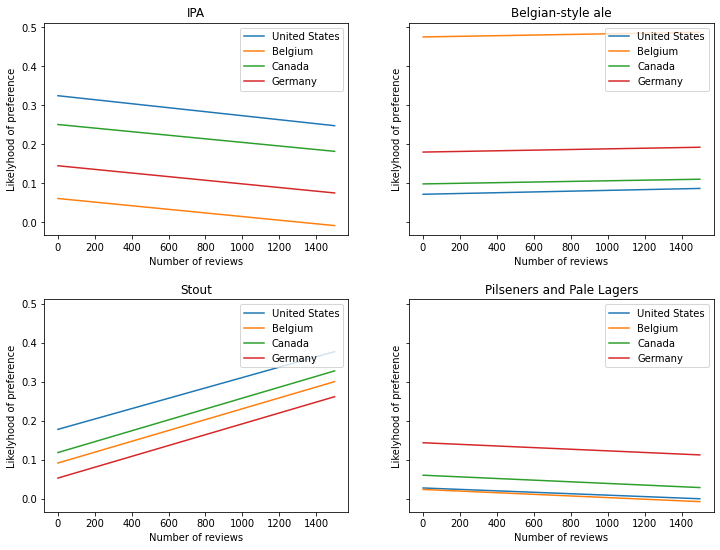

In [177]:
nb_ratings = np.arange(1, 1500)
fig, axes = plt.subplots(2, 2, figsize=(12, 9),sharey=True) 
plt.subplots_adjust(hspace=0.3)
#fig.suptitle("Main Title", fontsize=20)
countries = ["United States","Belgium","Canada","Germany"]
styles = ["IPA", "Belgian-style ale", "Stout", "Pilseners and Pale Lagers"]

for i in range(4):
    x,y = [0,0]
    if ((i+1) % 2) == 0: y = 1
    if (i>1): x = 1
    for j in range(4):
        axes[x,y].plot(nb_ratings,coefficients[i][j][0] + coefficients[i][j][1] * nb_ratings + coefficients[i][j][2],label=countries[j])

    axes[x,y].set_title(styles[i])
    axes[x,y].set_xlabel('Number of reviews')
    axes[x,y].set_ylabel('Likelyhood of preference')
    axes[x,y].legend(loc="upper right")
    
    

As we can see on the plots above, there is a clear difference of beer style preferences from one country to another. For example, a user from the United States will likely prefer IPA's or Stouts rather than Belgian-style ales. While a user from Belgium will likely prefer Belgian-style ales rather than IPA's. 

Another way to prove that user experience has an influence on the beer styles preferences would be to choose a set of "experienced" users and see how their preferences vary in time. In the following analysis we will compare the user preferences among the 100 first ratings with the user preferences among the 100 last ratings of users having done more than 400 ratings in total. 

We will compare the user preferences by conducting a type of paired statistical test called the The Wilcoxon signed-rank test. It tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test test, since our two populations are dependant.

In [196]:
# create a dictionary with only experienced users 
experienced_users_dict = {}
for key,group in df.loc[df["user_nbr_ratings"]>500].groupby("user_id"):
    experienced_users_dict[key] = pd.DataFrame(columns=['rating','date','style','country','user_nbr_ratings','user_nbr_reviews','user_country','style_merged'])
    group_sorted = group.sort_values(by="date")
    group_sorted["date"] = group_sorted["date"].apply(pd.to_datetime,unit='s')
    experienced_users_dict[key] = group_sorted[['rating','date','style','country','user_nbr_ratings','user_nbr_reviews','user_country','style_merged']]

In [316]:
# summerize the dictionary of experienced into a new dataframe by separating their style preferences when thaey first started rating beers and the most recent ratings they did 
experienced_users_summary = pd.DataFrame(columns=['user','country', 'main_country_rated_before', 'main_country_rated_after', 'fav_country_before', 'fav_country_after','main_style_rated_before','main_style_rated_after','fav_style_before','fav_merged_style_before','fav_style_after','fav_merged_style_after','total_ratings'])
for key in experienced_users_dict:
    by_user = {
        'user': [key],
        'country': [experienced_users_dict[key]["user_country"].iloc[0]],
        'main_country_rated_before':[experienced_users_dict[key].iloc[:10]["country"].value_counts().keys()[
            experienced_users_dict[key].iloc[:10]["country"].value_counts().argmax()]],
        'main_country_rated_after':[experienced_users_dict[key].iloc[-10:]["country"].value_counts().keys()[
            experienced_users_dict[key].iloc[-10:]["country"].value_counts().argmax()]],
        'fav_country_before':[experienced_users_dict[key].iloc[:10].sort_values(by="rating",ascending=False)["country"][:3].value_counts().keys()[
            experienced_users_dict[key].iloc[:10].sort_values(by="rating",ascending=False)["country"][:3].value_counts().argmax()]],
        'fav_country_after':[experienced_users_dict[key].iloc[-10:].sort_values(by="rating",ascending=False)["country"][:3].value_counts().keys()[
            experienced_users_dict[key].iloc[-10:].sort_values(by="rating",ascending=False)["country"][:3].value_counts().argmax()]],
        'main_style_rated_before': [experienced_users_dict[key].iloc[:10]["style"].value_counts().keys()[
            experienced_users_dict[key].iloc[:10]["style"].value_counts().argmax()]],
        'main_style_rated_after': [experienced_users_dict[key].iloc[-10:]["style"].value_counts().keys()[
            experienced_users_dict[key].iloc[-10:]["style"].value_counts().argmax()]],
        'fav_style_before':[experienced_users_dict[key].iloc[:10].sort_values(by="rating",ascending=False)["style"][:3].value_counts().keys()[
            experienced_users_dict[key].iloc[:10].sort_values(by="rating",ascending=False)["style"][:3].value_counts().argmax()]],
        'fav_merged_style_before':[experienced_users_dict[key].iloc[:50].sort_values(by="rating",ascending=False)["style_merged"][:1].value_counts().keys()[
            experienced_users_dict[key].iloc[:50].sort_values(by="rating",ascending=False)["style_merged"][:1].value_counts().argmax()]],
        'fav_style_after':[experienced_users_dict[key].iloc[-10:].sort_values(by="rating",ascending=False)["style"][:3].value_counts().keys()[
            experienced_users_dict[key].iloc[-10:].sort_values(by="rating",ascending=False)["style"][:3].value_counts().argmax()]],
        'fav_merged_style_after':[experienced_users_dict[key].iloc[-50:].sort_values(by="rating",ascending=False)["style_merged"][:1].value_counts().keys()[
            experienced_users_dict[key].iloc[-50:].sort_values(by="rating",ascending=False)["style_merged"][:1].value_counts().argmax()]],
        'total_ratings': [experienced_users_dict[key]["user_nbr_ratings"].iloc[0]],
    }
    experienced_users_summary = pd.concat([experienced_users_summary, pd.DataFrame(by_user)], axis=0)
    
experienced_users_summary.reset_index(drop=True, inplace=True)

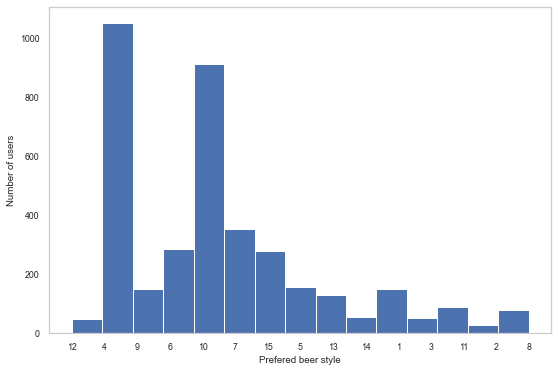

In [317]:
# Plot of histogram of prefered beer styles when the users didn't have much experience
a4_dims = (9, 6)
fig, ax = plt.subplots(figsize=a4_dims)
experienced_users_summary["fav_merged_style_before"].hist(ax=ax, bins=len(experienced_users_summary["fav_merged_style_before"].unique()))
ax.set_xlabel('Prefered beer style')
ax.set_ylabel('Number of users')
ax.grid(False)
plt.show()

This plot shows that when users don't have much experience, their 3 prefered styles are the IPA's, the stouts, and the belgian styles in order of preference.

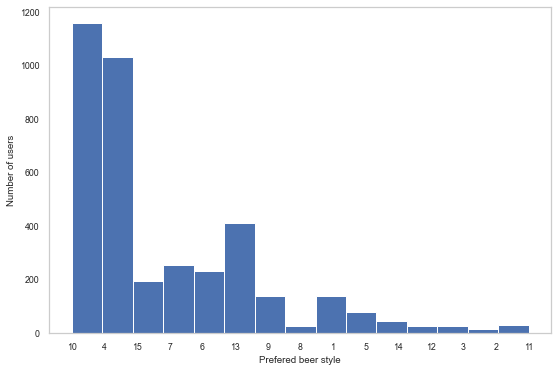

In [318]:
# Plot of histogram of prefered beer styles when the users have a lot of experience
a4_dims = (9, 6)
fig, ax = plt.subplots(figsize=a4_dims)
histogram = experienced_users_summary["fav_merged_style_after"].hist(ax=ax, bins=len(experienced_users_summary["fav_merged_style_before"].unique()))
ax.set_xlabel('Prefered beer style')
ax.set_ylabel('Number of users')
ax.grid(False)
plt.show()

This plot shows that when the users have a lot of experience, their 3 prefered styles are the stouts', the IPA's, and the scottish-style ales in order of preference.

We will now conduct the statistical test to see if this difference is significant.

In [319]:
# compute the 2 distributions
histogram_before = np.histogram(experienced_users_summary["fav_merged_style_before"].astype("int").values, bins=len(experienced_users_summary["fav_merged_style_before"].unique()))[0]
histogram_after = np.histogram(experienced_users_summary["fav_merged_style_after"].astype("int").values, bins=len(experienced_users_summary["fav_merged_style_after"].unique()))[0]

# Wilcoxon sign-rank test
stats.wilcoxon(histogram_before,histogram_after)

WilcoxonResult(statistic=29.0, pvalue=0.083251953125)

The p-value is between 0.05 and 0.1, thus we don't reject at a confidence level of 5% but we can reject it at a confidence level of 10%.

### Bayesian regression to sort even out the ratings